In [1]:
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI
from langgraph.graph import START,END,StateGraph
from langchain.messages import HumanMessage,AIMessage,SystemMessage,ToolMessage
from langgraph.types import Command,Send,RetryPolicy,interrupt
from typing import Literal,TypedDict,List
from langchain_core.prompts import PromptTemplate
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from pydantic import Field,BaseModel
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.checkpoint.memory import MemorySaver
from langgraph.runtime import Runtime
import nbformat
from nbformat.v4 import new_notebook, new_markdown_cell, new_code_cell
import os
from dotenv import load_dotenv
load_dotenv()

c:\Users\offic\OneDrive\Desktop\Python-Learning\Data Science\LangGraph-V1.0\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [ ]:
class CellFormat(BaseModel):
    cell_type: Literal["code","markdown"] = Field(...,description="The type of cell either code or markdown.")
    cell_no: int=Field(...,description="The cell number in which this particular markdown or code will go in.")
    cell_content: str=Field(...,description="The content that is to be written in the cell.")

class Code(BaseModel):
    topic: str=Field(...,description="The topic on which the Chapter is based upon.")
    cell: List[CellFormat]
    
class Context(TypedDict):
    course_name: str
    course_url : str
    
class Lesson(TypedDict):
    lesson_number: int
    lesson_name: str
    content: str
    
    
class LessonMemory(BaseModel):
    lesson_id: int
    key_concepts: List[str]
    intuitions: List[str]
    equations: List[str]
    code_primitives: List[str]

class Chapter(TypedDict):
    chapter_number: int
    chapter_name: str
    lessons : List[LessonMemory]


class SummarizerState(TypedDict):
    folder_path: str
    content: List[Chapter]
    

In [10]:
def sanitize_text(text: str) -> str:
    # Remove control characters
    bad_chars = ["\f", "\r", "\x0b", "\x0c"]
    for ch in bad_chars:
        text = text.replace(ch, "")
    
    # Normalize spaces
    text = " ".join(text.split())
    return text

import re

def fix_latex(text: str) -> str:
    text = sanitize_text(text)

    # Remove stray single $
    text = re.sub(r'(?<!\$)\$(?!\$)', '', text)

    # Ensure $$ pairs close
    if text.count("$$") % 2 != 0:
        text = text.replace("$$", "$")  # fallback to inline

    # Remove HTML math (model sometimes does this)
    text = re.sub(r"<\/?sup>", "", text)
    text = re.sub(r"<\/?sub>", "", text)

    return text
import re

def fix_mermaid(text: str) -> str:
    if "```mermaid" not in text:
        return text

    # Extract only inside mermaid block to avoid breaking other text
    pattern = r"```mermaid(.*?)```"
    matches = re.findall(pattern, text, flags=re.S)
    if not matches:
        return text

    fixed_blocks = []
    for block in matches:
        code = block.strip()

        # Ensure graph declaration is on its own line
        code = re.sub(r"(graph\s+(LR|TD))", r"\n\1\n", code)

        # Put keywords on newlines (LLM usually puts everything in one line)
        code = re.sub(r"\s*(subgraph)\s*", r"\n\1 ", code)
        code = re.sub(r"\s*(end)\s*", r"\n\1\n", code)

        # Put edges on their own lines
        code = re.sub(r"\s*-->\s*", r" --> ", code)
        code = re.sub(r"(\w[^\n]*-->[^\n]*)", r"\n\1", code)

        # Fix "" in labels  -> change ""Label"" to "Label"
        code = re.sub(r'\[""\s*([^"]+)\s*"\]', r'["\1"]', code)

        # Fix accidental double trailing quotes: ["abc""] -> ["abc"]
        code = re.sub(r'\["([^"]+)"+"\]', r'["\1"]', code)

        # Fix cases like Bedrooms""
        code = re.sub(r'"+"(\])', r'"\1', code)

        # Fix subgraph labels like   subgraph A Label with spaces
        code = re.sub(
            r"subgraph\s+([A-Za-z0-9_]+)\s+\[?\"?([^\"\]]+ ?)\"?\]?",
            r'subgraph \1["\2"]',
            code
        )

        fixed_blocks.append("```mermaid\n" + code.strip() + "\n```")

    # Replace old blocks with fixed blocks
    new_text = text
    for old, new in zip(matches, fixed_blocks):
        new_text = new_text.replace("```mermaid" + old + "```", new)

    return new_text

def clean_markdown_cell(text: str) -> str:
    text = sanitize_text(text)
    text = fix_latex(text)
    text = fix_mermaid(text)
    return text


In [2]:
prompt = f"""You are extracting structured learning memory from a single lesson transcript.

Your task is to convert the provided transcript into a LessonMemory object.
Focus ONLY on this lesson. Do NOT summarize the entire course or the entire week.

Guidelines:
- Extract atomic concepts, not explanations.
- Separate intuition from equations and code.
- Do NOT invent content that does not appear in the transcript.
- Do NOT repeat definitions that are explicitly stated as previously covered.
- Assume the reader has access to prior weeks' summaries if provided.

Diagram Rules (IMPORTANT):
- Generate Mermaid diagrams ONLY when a visual representation significantly improves understanding.
- Use diagrams for:
  - data flow
  - algorithm steps
  - architectural relationships
  - process pipelines
- Do NOT create diagrams for simple lists or trivial concepts.
- Mermaid code must be valid and self-contained.
- Prefer simple Mermaid types:
  - flowchart
  - sequenceDiagram
  - graph TD

Output Rules:
- Return ONLY valid JSON matching the LessonMemory schema.
- Do NOT include markdown, commentary, or explanations outside the schema.
- Do NOT generate notebook cells or formatting.

LessonMemory fields:

- lesson_id:
  Use the provided lesson_id exactly.

- week_id:
  Use the provided week_id exactly.

- title:
  Short descriptive title for this lesson.

- key_concepts:
  List of atomic concepts introduced or used in this lesson.
  Each item must be a short noun phrase (2-5 words).
  Do NOT include explanations, examples, or verbs.

- intuitions:
  High-level mental models that help understanding.
  Use simple language.
  Avoid equations, symbols, or code.

- equations:
  Core mathematical expressions that appear in the lesson.
  Use LaTeX-style math when appropriate.
  Skip derivations.

- code_primitives:
  Describe concrete coding demonstrations or implementations shown or discussed.
  Focus on intent, not full code.

- visual_primitives:
  A list of Mermaid diagram definitions as strings.
  Each item must contain ONLY valid Mermaid syntax.
  Do NOT wrap diagrams in markdown code fences.
  Do NOT include explanations or comments.

Context from previous weeks (if any):
{{previous_week_context}}

Lesson transcript:
{{lesson_transcript}}
"""

In [5]:
prompt.format(previous_week_context="Manas",lesson_transcript="Tiwari")

"You are extracting structured learning memory from a single lesson transcript.\n\nYour task is to convert the provided transcript into a LessonMemory object.\nFocus ONLY on this lesson. Do NOT summarize the entire course or the entire week.\n\nGuidelines:\n- Extract atomic concepts, not explanations.\n- Separate intuition from equations and code.\n- Do NOT invent content that does not appear in the transcript.\n- Do NOT repeat definitions that are explicitly stated as previously covered.\n- Assume the reader has access to prior weeks' summaries if provided.\n\nDiagram Rules (IMPORTANT):\n- Generate Mermaid diagrams ONLY when a visual representation significantly improves understanding.\n- Use diagrams for:\n  - data flow\n  - algorithm steps\n  - architectural relationships\n  - process pipelines\n- Do NOT create diagrams for simple lists or trivial concepts.\n- Mermaid code must be valid and self-contained.\n- Prefer simple Mermaid types:\n  - flowchart\n  - sequenceDiagram\n  - grap

In [14]:
def get_content(state: SummarizerState) -> Command[Literal["gen_content"]] :
    path = state["folder_path"]
    folders =  [entry.name for entry in os.scandir(path) if entry.is_dir()]

    chapters = []
    for folder in folders:
        
        chapter_no,chapter_name = folder.split('.',1)
        lesson_path = f"{path}//{folder}"
        lessons = [f for f in os.listdir(lesson_path) if os.path.isfile(os.path.join(lesson_path, f))]

        chapter: Chapter = {}
        chapter["chapter_number"]=chapter_no
        chapter["chapter_name"]=chapter_name
        chapter["lessons"] = []
        for lesson in lessons:
            lesson_no,lesson_name_raw = lesson.split("-",1)
            lesson_name,_ = lesson_name_raw.split(".",1)
            with open(f"{lesson_path}//{lesson}","r") as f:
                content = f.read()
            chapter["lessons"].append({"lesson_number":lesson_no,"lesson_name":lesson_name,"content":content})
        chapters.append(chapter)
        
    return Command(update={"content":chapters},goto="gen_content")

def gen_content(state:SummarizerState,runtime:Runtime[Context]) -> Command[Literal["create_nb"]]:
    course_name = runtime.context["course_name"]
    course_url = runtime.context["course_url"]
    
    model = ChatGoogleGenerativeAI(model="gemini-2.5-flash",temperature=0.2,top_p=0.9).with_structured_output(Code)
    chapters = state["content"]
    prompt = PromptTemplate(
        template="""
        You are an expert course note creator and teacher.

        Your job is to READ and UNDERSTAND the full lecture transcript and then
        create a HIGH-QUALITY, BEAUTIFULLY FORMATTED, EASY-TO-READ Jupyter Notebook
        that feels visually comfortable and well-structured.

        ***Please seperate code in to code cell not in Markdown cell.***
        DO NOT paste the transcript.
        DO NOT include unnecessary text.
        Teach clearly, concisely, and elegantly.

        ========================
        COURSE CONTEXT
        Course: {course_name}
        Link: {course_link}

        LECTURE TRANSCRIPT:
        {content}
        ========================


        OBJECTIVE
        Produce a notebook that is:
        - clean
        - well spaced
        - visually pleasant
        - minimal but meaningful
        - highly readable for students

        The notebook should NOT look cluttered or loud.


        ========================
        NOTEBOOK LAYOUT (STRICT)
        Use headings CAREFULLY and CONSISTENTLY.

        HEADING RULES
        # is ONLY allowed ONCE for the main title.
        ## for section titles
        ### for subsections
        Do NOT use huge heading spam.

        Add small spacing using short paragraphs and bullet lists.
        Prefer clarity over density.


        ========================
        NOTEBOOK CONTENT FORMAT
        
        1. Pretend a student studies ONLY this notebook.
        Make it:
        - structured
        - elegant
        - use bullets not long paragraphs.
        - visually comfortable
        - logically organized
        - NOT overly long
        - NOT overly short

        2. Visual Understanding
        ## Visual Understanding

        RULE:
        - Prefer **clear explanation**
        - If appropriate:
        - Use Mermaid ONLY for flow / conceptual diagrams
        - NEVER try to draw charts or curves with Mermaid
        - If visual relationship needs a graph → provide matplotlib code instead.


        3. Important Formulas (Math Section)
        ## Important Formulas

        Use VALID LaTeX.
        Rules:
        - Wrap in $$ block math $$ OR \( inline math \)
        - No broken braces
        - If unsure about correctness → write English explanation instead.

        ========================
        STRICT VISUAL QUALITY RULES
        - Do NOT use massive headings everywhere
        - Title → # only ONCE
        - Sections → ##
        - Subsections → ###
        - No walls of text
        - Prefer bullets + spacing
        - Keep notebook compact but meaningful
        - Make it enjoyable to scroll through

        MATH & SYMBOL RULES
        - NEVER use HTML tags like <sup>, <sub>, <b>, <i>, <span>
        - ALWAYS use LaTeX MathJax formatting
        - For superscripts: 'n^curlybrackets[l]'
        - Inline math: \( ... \)
        - Block math: $$ ... $$
        - If LaTeX is uncertain → write in plain text instead of broken formatting
        - No broken formulas
        - No unmatched braces
        - If risky → explain in English instead


        ========================
        DIAGRAM RULES
        Allowed Mermaid uses:
        - flowcharts
        - mindmaps
        - conceptual or process diagrams
        MERMAID RULES
        - Subgraph names must NOT contain spaces
        Use: Input_Layer , Hidden_Layer
        - If you want a pretty title use:
        subgraph Input_Layer["Input Layer"]
        - Node labels with spaces MUST be quoted:
        X2["Zip Code"]
        - NEVER use # inside node labels
        - Prefer flowchart relationships, not charts
        Forbidden:
        - charts
        - line plots
        - performance curves
        - axes-based visuals

        If chart needed:
        Generate clean matplotlib Python code instead.
        
        


        Return output STRICTLY in the structured schema also strictly avoid using long paragraphs use bullet points instead.

        """,
        input_variables=["course_name","course_link","content"]
    )
    chain = prompt | model
    inputs = [{"course_name":course_name,"course_link":course_url,"content":x} for x in chapters]

    responses = chain.batch(inputs)
    
    
    updated_chapters = [
        {**chapter, "generated_content": responses[i]}
        for i, chapter in enumerate(chapters)
    ]

    return Command(update={"content": updated_chapters},goto="create_nb")
    

def create_nb(state:SummarizerState)->Command[Literal[END]]:
    chapters = state["content"]
    nb = new_notebook()
    nb.cells = []

    for chapter in chapters :
        code_details = chapter["generated_content"]
        nb.cells.append(new_markdown_cell(f"# {code_details.topic}"))

        for cell in code_details.cell:
            content = cell.cell_content

            if isinstance(content, str):
                content = content.encode("utf-8").decode("unicode_escape")

            if cell.cell_type == "markdown":
                content = clean_markdown_cell(content)
                nb.cells.append(new_markdown_cell(content))
            else:
                nb.cells.append(new_code_cell(content))

    with open("generated_notebook.ipynb", "w", encoding="utf-8") as f:
        nbformat.write(nb, f)

    print("Notebook generated Successfully !!")
    return Command(goto=END)
        

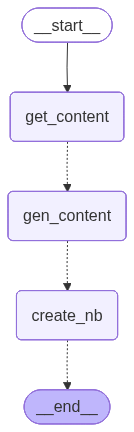

In [15]:
workflow = StateGraph(state_schema=SummarizerState,context_schema=Context)
workflow.add_node("get_content",get_content)
workflow.add_node("gen_content",gen_content)
workflow.add_node("create_nb",create_nb)
workflow.add_edge(START,"get_content")
workflow.add_edge("create_nb",END)
graph = workflow.compile()
graph

In [16]:
folder_path="./transcripts"
results = graph.invoke({"folder_path":folder_path},context=Context(course_name="neural-networks-deep-learning",course_url="https://www.coursera.org/learn/neural-networks-deep-learning"))

Notebook generated Successfully !!


C:\Users\offic\AppData\Local\Temp\ipykernel_30536\666092217.py:195: DeprecationWarning: invalid escape sequence '\('
  content = content.encode("utf-8").decode("unicode_escape")
C:\Users\offic\AppData\Local\Temp\ipykernel_30536\666092217.py:195: DeprecationWarning: invalid escape sequence '\s'
  content = content.encode("utf-8").decode("unicode_escape")
C:\Users\offic\AppData\Local\Temp\ipykernel_30536\666092217.py:195: DeprecationWarning: invalid escape sequence '\h'
  content = content.encode("utf-8").decode("unicode_escape")
C:\Users\offic\AppData\Local\Temp\ipykernel_30536\666092217.py:195: DeprecationWarning: invalid escape sequence '\m'
  content = content.encode("utf-8").decode("unicode_escape")
C:\Users\offic\AppData\Local\Temp\ipykernel_30536\666092217.py:195: DeprecationWarning: invalid escape sequence '\p'
  content = content.encode("utf-8").decode("unicode_escape")
C:\Users\offic\AppData\Local\Temp\ipykernel_30536\666092217.py:195: DeprecationWarning: invalid escape sequenc

In [10]:
results

{'folder_path': './transcripts',
 'content': [{'chapter_number': '1',
   'chapter_name': 'Introduction_to_deep_learning',
   'lessons': [{'lesson_number': '01',
     'lesson_name': 'welcome',
     'content': "Hello and welcome.\nAs you probably know,\ndeep learning has already transformed\ntraditional internet businesses like web search and advertising.\nBut deep learning is also enabling\nbrand new products and businesses and ways of helping people to be created.\nEverything ranging from better healthcare,\nwhere deep learning is getting really good at reading\nX-ray images to delivering personalized education,\nto precision agriculture, to even self driving cars and many others.\nIf you want to learn the tools of deep learning and\nbe able to apply them to build these amazing things,\nI want to help you get there.\nWhen you finish the sequence of courses on Coursera,\ncalled the specialization, you will be able to put\ndeep learning onto your resume with confidence.\nOver the next de

In [45]:
from langchain_core.prompts import PromptTemplate


prompt = PromptTemplate(
    template="""Generate an appropriate theme for the given description about an image.
Description:
{code_content}
""",
    input_variables=["code_content"]
)

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

# Create chain
chain = prompt | llm

# Multiple inputs -> each becomes one LLM call (in parallel)
inputs = [
    {"code_content": "A calm sunset over a lake with soft orange light"},
    {"code_content": "Cyberpunk city with neon lights and rain at night"},
    {"code_content": "A kid playing football in a village ground with mountains behind"},
]

responses = chain.batch(inputs)

for r in responses:
    print(r)


content="Here are a few appropriate themes, ranging from direct to more evocative:\n\n**Simple & Direct:**\n*   Sunset Serenity\n*   Lakeside Glow\n*   Orange Dusk\n\n**More Evocative/Poetic:**\n*   Golden Hour Tranquility\n*   Dusk's Gentle Embrace\n*   Still Waters, Warm Light\n*   A Calm Canvas\n\n**My top recommendation would be:**\n\n**Sunset Serenity** or **Golden Hour Tranquility**" additional_kwargs={} response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'} id='lc_run--019b3f93-7201-7c71-9b5f-4ebf1219114c-0' usage_metadata={'input_tokens': 28, 'output_tokens': 836, 'total_tokens': 864, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 737}}
content='Here are several appropriate themes for an image of a "Cyberpunk city with neon lights and rain at night," ranging from direct to more evocative:\n\n1.  **Neon Noir:** (Classic and highly fitting, combining the visual style wi

In [ ]:
import os

path = "./transcripts"
folders =  [entry.name for entry in os.scandir(path) if entry.is_dir()]

chapters = []
for folder in folders:
    
    chapter_no,chapter_name = folder.split('.',1)
    lesson_path = f"{path}//{folder}"
    lessons = [f for f in os.listdir(lesson_path) if os.path.isfile(os.path.join(lesson_path, f))]

    chapter: Chapter = {}
    chapter["chapter_number"]=chapter_no
    chapter["chapter_name"]=chapter_name
    chapter["lessons"] = []
    for lesson in lessons:
        lesson_no,lesson_name_raw = lesson.split("-",1)
        lesson_name,_ = lesson_name_raw.split(".",1)
        with open(f"{lesson_path}//{lesson}","r") as f:
            content = f.read()
        chapter["lessons"].append({"lesson_number":lesson_no,"lesson_name":lesson_name,"content":content})
    chapters.append(chapter)